<img src="http://oci02.img.iteso.mx/identidad_de_instancia_2018/ITESO/Logos%20ITESO/Logo-ITESO-Principal.jpg">

  ---

<center> <font color= #004A94> <font size = 5> Ingeniería Financiera | ITESO </font> <br> <br>

<center> <font color= #004A94> <font size = 6> Microestructura y Sistemas de Trading </font> <br> <br>

<center> <font color=#42c29b><font size=5> Laboratorio 2 <br> <br> Behavioral Finance en Trading </font> <br> <br>

<center> <font color=#004A94><font size=4> I.F. Victor Mauricio Anaya Avalos | if702705@iteso.mx </font> <br> <br>

  ---

# Abstract

## El objetivo de este laboratorio es desarrollar las herramientas necesarias para realizar un análisis de desempeño de la actividad de una cuenta de trading. Se evaluarán tanto a la cuenta, como a la persona que operó la cuenta. Para realizar este análisis de manera completa, es necesario dividir el trabajo en 3 partes que a continuación se describirán:

### Librerías necesarias

In [ ]:
import pandas as pd
import numpy as np
import math as math

### Análisis de histórico de cuenta

##### - Estádistica Básica: en este apartado, se desarrolla el algoritmo necesario para realizar diferentes tareas, en estas se incluyen las siguientes: obtener un DataFrame con la información de datos históricos de una cuenta, calcular el tamaño de pips correspondiente a cada par de divisas, expresar ganancia o pérdida en pips, obtener pips y profit acumulado, así como generar un DataFrame que muestre a grandes rasgos información de la cuenta (operaciones totales, operaciones ganadoras y perdedoras, % efectividad, etc.) y un DataFrame que describe el ranking de cada par de divisas con el que se realizó una operación.

Función que importa el archivo a analizar y lo prepara para su lectura; modifica a minúsculas el nombre de las columnas, convirtie ciertas columnas a datos tipo númerico y genera un DataFrame con la información del archivo:

In [1]:
def f_leer_archivo(param_archivo):
    """"
    Parameters
    ----------
    param_archivos : str : nombre de archivo a leer

    Returns
    -------
    df_data : pd.DataFrame : con informacion contenida en archivo leido

    Debugging
    ---------
    param_archivo =  'trading_historico.xlsx'

    """
    # Leer archivo de datos y guardarlo en Data Frame
    df_data = pd.read_excel('Archivos/' + param_archivo, sheet_name='Hoja1')

    # Convertir a minusculas el nombre de las columnas
    df_data.columns = [list(df_data.columns)[i].lower() for i in range(0, len(df_data.columns))]
    
    # Asegurar que ciertas columnas son tipo numerico
    numcols =  ['s/l', 't/p', 'commission', 'openprice', 'closeprice', 'profit', 'size', 'swap', 'taxes']
    df_data[numcols] = df_data[numcols].apply(pd.to_numeric)

    return df_data

Función que asigna a cada par de divisas un multiplicador necesario para obtener los pips correspondientes por par de divisa:

In [2]:
def f_pip_size(param_ins):
    """"
    Parameters
    ----------
    param_ins : str : nombre de instrumento 

    Returns
    -------
    pips_inst : 

    Debugging
    ---------
    param_ins =  'trading_historico.xlsx'

    """
    
    ""
    
    # encontrar y eliminar diferentes "typos" que dificultan la lectura
    inst = param_ins.replace('_', '')
    inst = param_ins.replace('-2', '')
    
    # transformar a minusculas
    inst = inst.lower()
    
    #lista de pips por instrumento
    pips_inst =  {'audusd' : 10000, 'gbpusd': 10000, 'xauusd': 10, 'eurusd': 10000, 'xaueur': 10,
                  'nas100usd': 10, 'us30usd': 10, 'mbtcusd':100, 'usdmxn': 10000, 'eurjpy':100, 
                  'gbpjpy':100, 'usdjpy':100, 'btcusd':10, 'eurgbp':10000, 'usdcad':10000,}
    
    return pips_inst[param_ins]

Función que calcula el tiempo que estuvo abierta una operación y la agrega como columna al DataFrame original:

In [ ]:
def f_columnas_tiempo(param_data):

#convertir columna de 'closetime' y 'opentime' utilizando pd.to_datetime
    param_data['closetime'] = pd.to_datetime(param_data['closetime'])
    param_data['opentime'] = pd.to_datetime(param_data['opentime'])
    
    param_data['tiempo'] = [(param_data.loc[i, 'closetime'] - param_data.loc[i, 'opentime']).delta / 1*np.exp(9)
    for i in range(0, len(param_data['closetime']))]
    
    return param_data

Función que obtiene el resultado de pips por operación - tanto compra, como venta - y las agrega como columna al DataFrame original:

- se adjunta imagen con un fragmento del DataFrame que contiene estas funciones ya como columnas

In [ ]:
def f_columnas_pips(param_data):
    param_data['pips'] = np.zeros(len(param_data['type']))
    for i in range(0,len(param_data['type'])):
        if param_data['type'][i] == 'buy':
            param_data['pips'][i] = (param_data.closeprice[i] - param_data.openprice[i])*f_pip_size(param_ins=param_data['symbol'][i])
        else:
            param_data['pips'][i] = (param_data.openprice[i] - param_data.closeprice[i])*f_pip_size(param_ins=param_data['symbol'][i])
    
    param_data['pips_acm'] = np.zeros(len(param_data['type']))
    param_data['profit_acm'] = np.zeros(len(param_data['type']))    
    param_data['pips_acm'][0] = param_data['pips'][0]
    param_data['profit_acm'][0] = param_data['profit'][0]
            
    for i in range(1,len(param_data['pips'])):
         param_data['pips_acm'][i] = param_data['pips_acm'][i-1] + param_data['pips'][i]
         param_data['profit_acm'][i] = param_data['profit_acm'][i-1] + param_data['profit'][i]
        
    return param_data

*imagen:
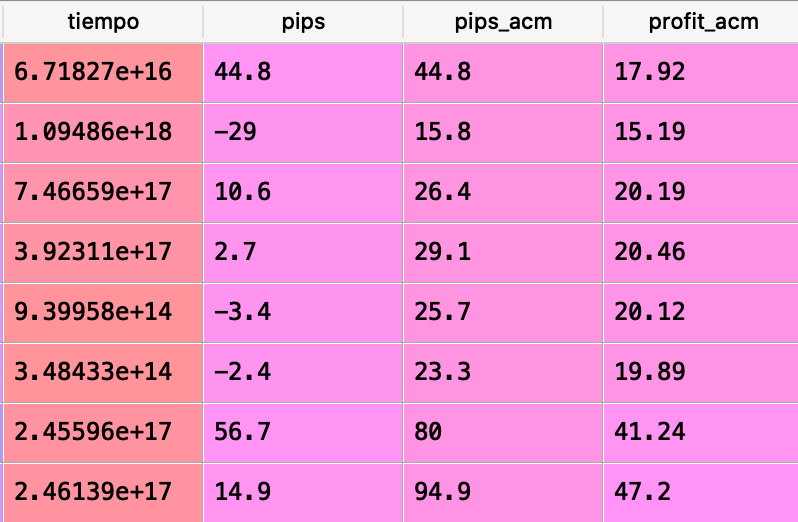

Función que crea un diccionario en el que se guardan 2 DataFrames. "**df_1_tabla**" contiene  diferentes cálculos de información de tipo estadística; mientras que "**df_2_ranking**" contiene un ranking ordenado jerárquicamente - basado en un ratio de efectividad - de cada par de divisas con el que se operó:
- se adjunta imagen que valida los resultados

In [3]:
def f_estadisticas_ba(param_data):
    
    medida = ['Ops totales', 'Ganadoras', 'Ganadoras_c', 'Ganadoras_v', 'Perdedoras', 'Perdedoras_c', 'Perdedoras_v', 
              'Media(profit)','Media(pips)', 'r_efectividad', 'r_proporcion', 'r_efectividad_c','r_efectividad_v']
    descripcion = ['Operaciones Totales', 'Operaciones Ganadoras', 'Operaciones Ganadoras de Compra', 'Operaciones Ganadoras de Venta',
                   'Operaciones Perdedoras', 'Operaciones Perdedoras de Compra', 'Operaciones Perdedoras de Venta', 'Mediana de Profit de Operaciones', 
                   'Media de Pips de Operaciones', 'Ganadoras Totales / Operaciones Totales', 'Perdedoras Totales / Ganadoras Totales',
                   'Ganadoras Compras / Operaciones Totales', 'Ganadoras Ventas / Operaciones Totales']
   
    zero_data = np.zeros(shape=(len(descripcion),3))
    df_1_tabla = pd.DataFrame(zero_data, columns = ['medida', 'valor', 'descripcion'])
    
    df_1_tabla['valor'][0] = len(param_data['profit'])
    df_1_tabla['valor'][1] = param_data['profit'].gt(0).sum()
    x = 0
    for i in range(0,len(param_data['type'])): 
        if param_data['type'][i] == 'buy' and param_data['profit'][i] > 0 :
            x = x+1
    df_1_tabla['valor'][2] = x
    
    x = 0
    for i in range(0,len(param_data['type'])): 
        if param_data['type'][i] == 'sell' and param_data['profit'][i] > 0 :
            x = x+1
    df_1_tabla['valor'][3] = x
    df_1_tabla['valor'][4] = df_1_tabla['valor'][0] - df_1_tabla['valor'][1]
    x = 0
    for i in range(0,len(param_data['type'])): 
        if param_data['type'][i] == 'buy' and param_data['profit'][i] < 0 :
            x = x+1
    df_1_tabla['valor'][5] = x
    
    x = 0
    for i in range(0,len(param_data['type'])): 
        if param_data['type'][i] == 'sell' and param_data['profit'][i] < 0 :
            x = x+1
    df_1_tabla['valor'][6] = x
    df_1_tabla['valor'][7] = param_data.profit.median()
    df_1_tabla['valor'][8] = param_data.pips.median()
    df_1_tabla['valor'][9] = df_1_tabla['valor'][0] / df_1_tabla['valor'][1]
    df_1_tabla['valor'][10] = df_1_tabla['valor'][1] / df_1_tabla['valor'][4]
    df_1_tabla['valor'][11] = df_1_tabla['valor'][0] / df_1_tabla['valor'][2] 
    df_1_tabla['valor'][12] = df_1_tabla['valor'][0] / df_1_tabla['valor'][3] 
    
    for i in range(0,len(medida)):
        df_1_tabla['medida'][i] = medida[i]
        df_1_tabla['descripcion'][i] = descripcion[i]


    symbols = param_data["symbol"].unique().tolist()
    zero_data = np.zeros(shape=(len(symbols),2))
    df_2_ranking = pd.DataFrame(zero_data, columns = ['Symbol', 'Rank'])    

    for i in range(0,len(symbols)):
        df_2_ranking['Symbol'][i] = symbols[i]
        
    for i in range(0,len(df_2_ranking['Symbol'])):
        win =  0
        total = 0
        for k in range (0,len(param_data['symbol'])):
            if df_2_ranking['Symbol'][i] == param_data['symbol'][k]:
                total = total + 1
                if param_data['profit'][k] > 0:
                    win = win + 1
                    
        df_2_ranking['Rank'][i] = win / total
        
    dicci = {'df_2_ranking':df_2_ranking, 'df_1_tabla':df_1_tabla}
        
    return dicci

Diccionario con 2 llaves:
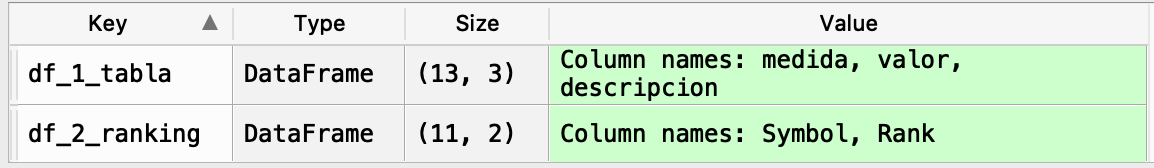

df_1_tabla|df_2_ranking
:-: | :-:
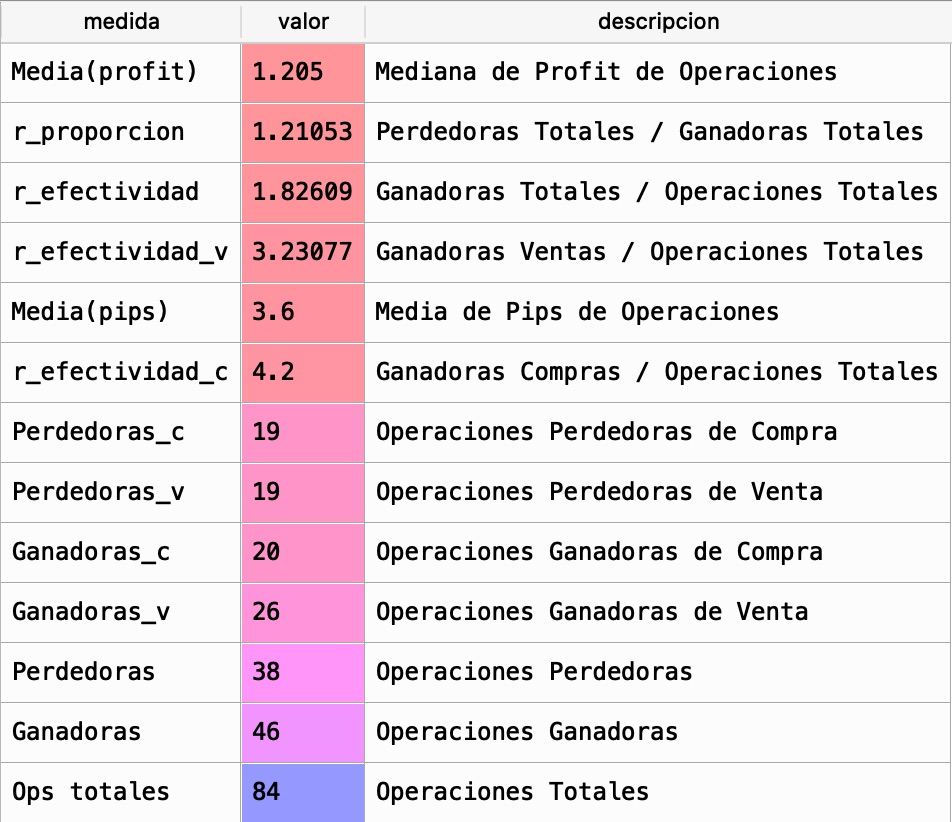|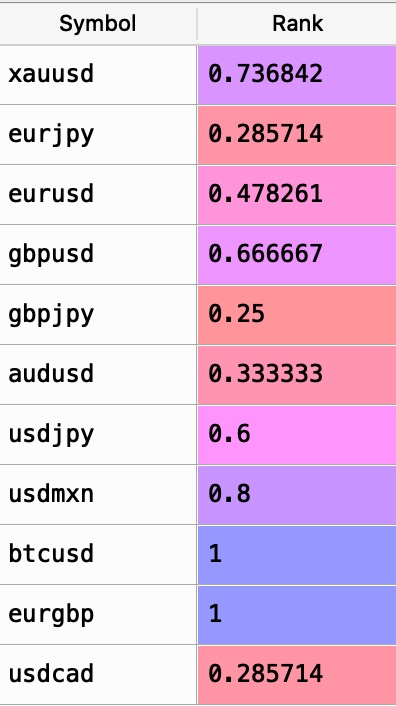

### Medidas de atribución al desempeño

- Medidas de Atribución al Desempeño: en este rubro, se generan diferentes métricas que ayudan a evaluar el desempeño de la cuenta y así obtener información más precisa y/o digerible. Dentro de las métricas calculadas se incluyen ratios como el de Sharpe y Sortino, así como cálculos tanto del DrawDown como el DrawUp de la cuenta.

Función que calcula el capital acumulado a lo largo de todas las operaciones y lo agrega como columna al DataFrame original:

In [ ]:
def f_capital_acum(param_data):
    
    param_data['capital_acm'] = np.zeros(len(param_data['type']))
    param_data['capital_acm'][0] = 5000+param_data['profit'][0]
            
    for i in range(1,len(param_data['pips'])):
         param_data['capital_acm'][i] = param_data['capital_acm'][i-1] + param_data['profit'][i]

    return param_data  

Función que calcula el profit neto por día, así como el profit acumulado diario y los rendimientos logarítmicos y crea un DataFrame con estas nuevas columnas:

In [ ]:
def f_profit_diario(param_data):
    
    fechas = param_data["closetime"].tolist()
    fechas = pd.to_datetime(fechas)
    zero_data = np.zeros(shape=(len(fechas),1))
    df_profit_d = pd.DataFrame(zero_data, columns = ['Fecha'])
    
    for i in range (0,len(fechas)):
        df_profit_d['Fecha'][i] = fechas[i]
    
    for i in range(0,len(df_profit_d["Fecha"])):
        df_profit_d["Fecha"][i] = df_profit_d["Fecha"][i].date()
        
    fechas =  df_profit_d["Fecha"].unique().tolist()
    zero_data = np.zeros(shape=(len(fechas),4))
    df_profit_d = pd.DataFrame(zero_data, columns = ['Timestamp','Profit Diario', 'Profit Acumulado Diario', 'Rendimientos Log'])
    
    for i in range(0,len(fechas)):
        df_profit_d['Timestamp'][i] = fechas[i]
        
    for i in range(0,len(df_profit_d['Timestamp'])):
        a =  0
        for k in range (0,len(param_data['closetime'])):
            if df_profit_d['Timestamp'][i] == param_data['closetime'][k].date():
                a = a + param_data['profit'][k]
                
        df_profit_d['Profit Diario'][i] = a
        df_profit_d = df_profit_d.sort_values(by=['Timestamp'])
        df_profit_d = df_profit_d.reset_index(drop=True)
        
        df_profit_d['Profit Acumulado Diario'][0] = 5000+df_profit_d['Profit Diario'][0]
        df_profit_d['Rendimientos Log'][0] = np.log(df_profit_d['Profit Acumulado Diario'][0]/5000)
        
    for i in range(1,len(df_profit_d['Profit Diario'])):
         df_profit_d['Profit Acumulado Diario'][i] = df_profit_d['Profit Acumulado Diario'][i-1] + df_profit_d['Profit Diario'][i]
         df_profit_d['Rendimientos Log'][i] = np.log(df_profit_d['Profit Acumulado Diario'][i]/df_profit_d['Profit Acumulado Diario'][i-1])
    
    return df_profit_d

Función que calcula diferentes medidas de atribución al desemepeño (Sharpe Ratio, Sortino Ratio, DrawDown, DrawUp e Information Ratio) y genera un DataFrame con estas medidas:

In [ ]:
def f_estadisticas_mad(param_data):
    rf = .08/300
    metrica = ['Sharpe', 'Sortino_c','Sortino_v','Drawdown_cap','Drawdown_cap','Information_r']
    descripcion = ['Sharpe Ratio', 'Sortino Ratio para Posiciones de Compra','Sortino Ratio para Posiciones de Venta',
                   'DrawDown de Capital', 'DrawUp de Capital','Information Ratio']
   
    zero_data = np.zeros(shape=(len(descripcion),3))
    df_mad = pd.DataFrame(zero_data, columns = ['Metrica', 'Valor', 'Descripcion'])
    
    for i in range(0,len(metrica)):
        df_mad['Metrica'][i] = metrica[i]
        df_mad['Descripcion'][i] = descripcion[i]

    df_mad['Valor'][0] = (param_data['Rendimientos Log'].mean()-rf) / param_data['Rendimientos Log'].std()
    df_mad['Valor'][1] = 0
    df_mad['Valor'][2] = 0
    df_mad['Valor'][3] = 0
    df_mad['Valor'][4] = 0
    df_mad['Valor'][5] = 0

    return df_mad

### Behavioral Finance

- Behavioural Finance: en esta sección, se le da énfasis al usuario a cargo de la cuenta y se definen diferentes funciones con el objetivo de obtener evidencia sobre los distitntos sesgos en los que incurre un trader.